[*********************100%***********************]  1 of 1 completed

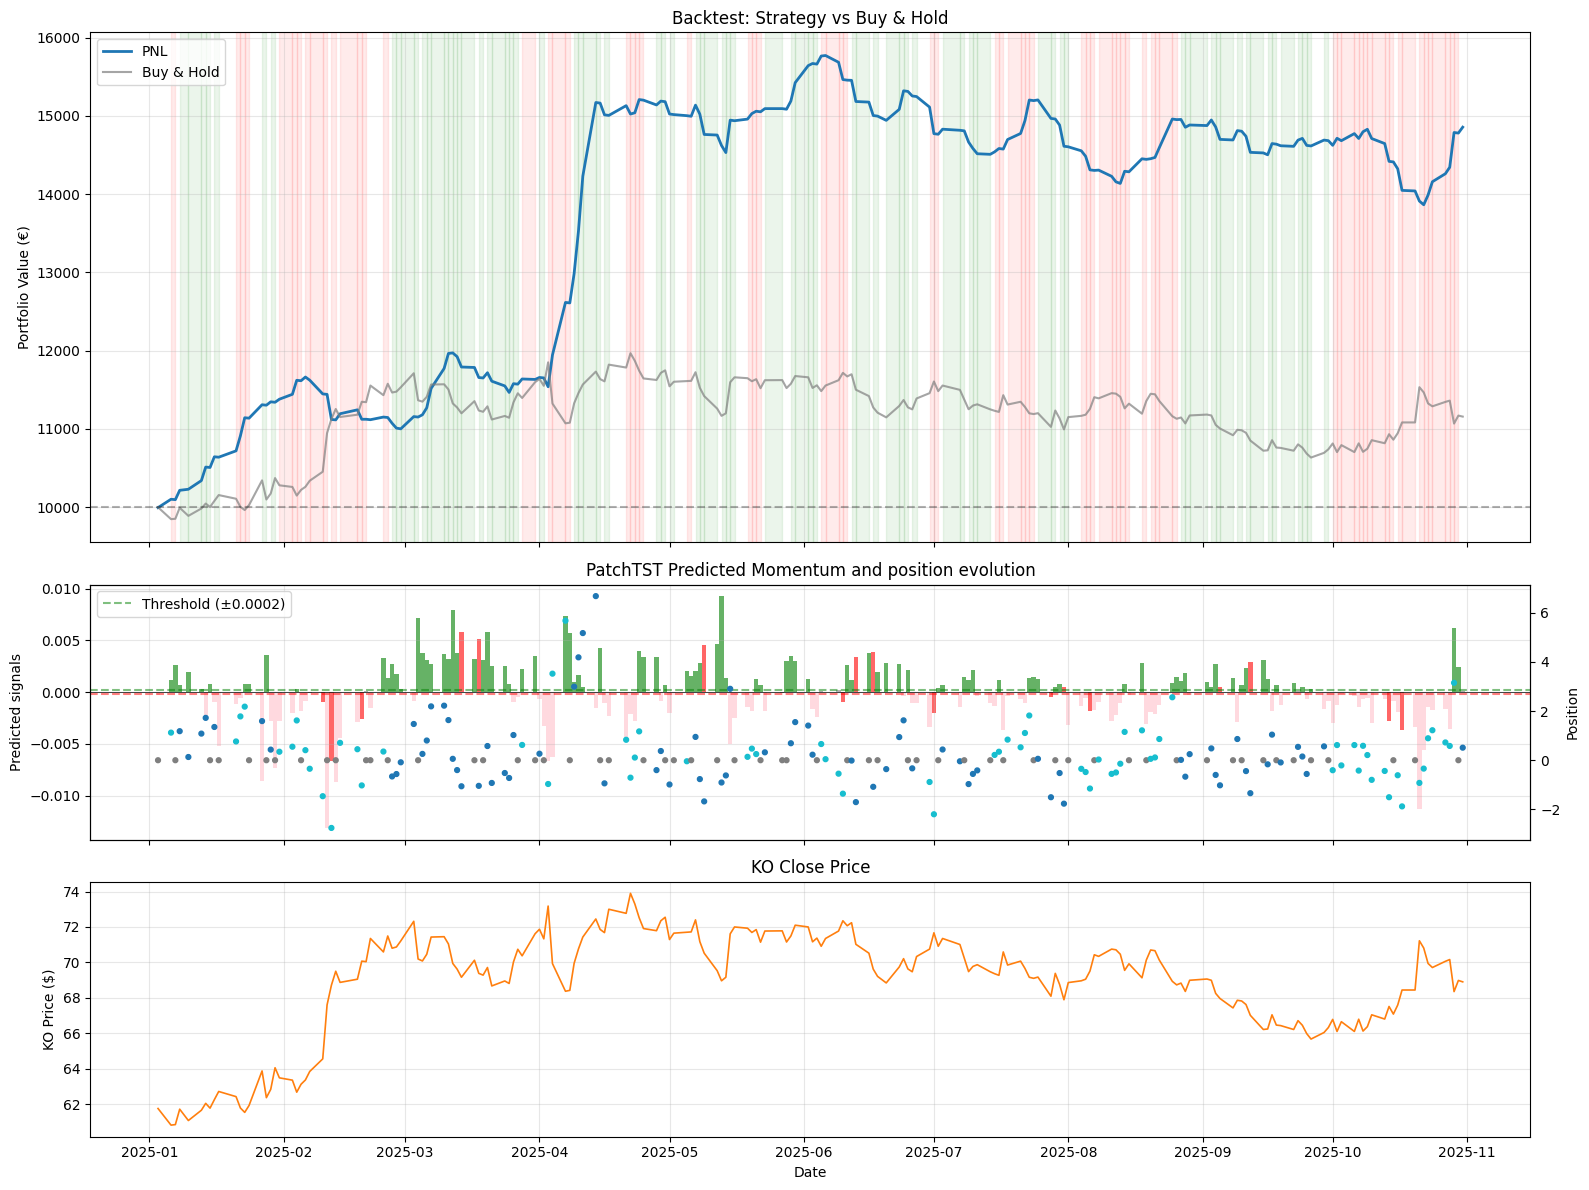

Strategy Return:   +48.56%
Buy & Hold Return: +11.58%
Signal Changes:    97
Long/Short/Flat:   92 / 91 / 8 days


In [ ]:
#from joblib.testing import param
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import os

#logfile = 'from_trained_test_ohlc.csv'
from lib.tradeparams import Params, TradeSimulationStats, load_params_from_json
from pathlib import Path

logfolder = Path('test_ohlc/KO')
logfile = logfolder / 'from_trained_test_ohlc.csv'

params_file = logfile.with_suffix('.json')

params:Params = load_params_from_json(params_file)

THRESHOLD = params.THRESHOLD
# Log einlesen
period_test  = {'start': params.trading_start, 'end': params.trading_end}
from ticker_data import get_ticker
df_log = pd.read_csv(logfile, parse_dates=['date'], index_col='date')

df_log.index = pd.to_datetime(df_log.index).tz_localize(None).normalize()


df_traded_symbol = get_ticker(params.traded_symbol,
                     start=params.trading_start, 
                     end=params.trading_end)

df_traded_symbol_closes = df_traded_symbol['Close'].squeeze()
df_traded_symbol_closes.index = pd.to_datetime(df_traded_symbol_closes.index).tz_localize(None).normalize()
df_traded_symbol_bt = df_traded_symbol_closes.reindex(df_log.index)          # NaN where missing

# Buy & Hold normalisiert auf gleichen Startwert
bh_normalized = df_traded_symbol_bt / df_traded_symbol_bt.iloc[0] * 10000

fig, axes = plt.subplots(3, 1, figsize=(16, 12), sharex=True,
                         gridspec_kw={'height_ratios': [2, 1, 1]})

# --- Plot 1: Portfolio P&L vs Buy & Hold ---
ax1 = axes[0]
ax1.plot(df_log.index, df_log['portfolio_value'], label='PNL', linewidth=2, color='tab:blue')

ax1.plot(bh_normalized.index, bh_normalized.values, label='Buy & Hold', linewidth=1.5, color='tab:gray', alpha=0.7)
ax1.axhline(10000, color='black', linestyle='--', alpha=0.3)
ax1.set_ylabel('Portfolio Value (€)')
ax1.set_title('Backtest: Strategy vs Buy & Hold')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

#ax3.relim()               # recompute limits from artists on the axes
#ax3.autoscale_view(scalex=False, scaley=True)  # only autoscale y

# Mark the area where we were in the market
for j in range(len(df_log) - 1):
    in_the_market = df_log['in_market'].iloc[j]
    if in_the_market == 1:
        ax1.axvspan(df_log.index[j], df_log.index[j+1], alpha=0.08, color='green')
    elif in_the_market == -1:
        ax1.axvspan(df_log.index[j], df_log.index[j+1], alpha=0.08, color='red')

# --- Plot 2: Predicted signals + Threshold ---
ax2 = axes[1]
colors = ['green' if s == 1 else 'pink' if s == -1 else 'red' if s == -2  else 'gray' for s in df_log['signal']]
ax2.bar(df_log.index, df_log['pred_momentum'], color=colors, alpha=0.6, width=1)
ax2.axhline(THRESHOLD, color='green', linestyle='--', alpha=0.5, label=f'Threshold (±{THRESHOLD})')
ax2.axhline(-THRESHOLD, color='red', linestyle='--', alpha=0.5)
ax2.axhline(0, color='black', linewidth=0.5)
ax2.set_ylabel('Predicted signals')
ax2.set_title('PatchTST Predicted Momentum and position evolution')
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3)

#draw position evolution
ax_openpos = ax2.twinx()
pos_return_normalized =  100
position_return = df_log['position_return'] * pos_return_normalized
color_map = {-2: 'tab:red', -1: 'tab:red', 0: 'tab:gray', 1: 'tab:green', 2: 'tab:green'}
colors = df_log['in_market'].map(color_map)
ax_openpos.scatter(df_log.index, position_return, c=colors, s=12, label='Position')
ax_openpos.set_ylabel('Position')

ax3 = axes[2]

ax3.plot(df_traded_symbol_bt.index, df_traded_symbol_bt.values, color='tab:orange', linewidth=1.2)

ax3.set_ylabel(f'{params.traded_symbol} Price ($)')
ax3.set_title(f'{params.traded_symbol} Close Price')
ax3.set_xlabel('Date')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig( logfolder /'result.png', dpi=150, bbox_inches='tight')
plt.show()

# Statistiken
total_return = (df_log['portfolio_value'].iloc[-1] / 10000 - 1) * 100
bh_return = (df_traded_symbol_bt.iloc[-1] / df_traded_symbol_bt.iloc[0] - 1) * 100
n_signals = (df_log['signal'].diff().fillna(0) != 0).sum()
long_days = (df_log['in_market'] == 1).sum()
short_days = (df_log['in_market'] == -1).sum()
flat_days = (df_log['in_market'] == 0).sum()

print(f"Strategy Return:   {total_return:+.2f}%")
print(f"Buy & Hold Return: {bh_return:+.2f}%")
print(f"Signal Changes:    {n_signals}")
print(f"Long/Short/Flat:   {long_days} / {short_days} / {flat_days} days")